# TP CUDA - October 2022
## Part 1 : Pi
### Compilation

In [3]:
!g++ -o binaries/tp_openmp_part_1_pi binaries/tp_openmp_part_1_pi.cpp -fopenmp -O3 -march=native
!nvcc -o binaries/tp_openmp_part_1_pi_basic_atomic binaries/tp_openmp_part_1_pi_basic_atomic.cu -Xcompiler -fopenmp -O3
!nvcc -o binaries/tp_openmp_part_1_pi_partial_sum binaries/tp_openmp_part_1_pi_partial_sum.cu -Xcompiler -fopenmp -O3
!nvcc -o binaries/tp_openmp_part_1_pi_partial_reduction binaries/tp_openmp_part_1_pi_partial_reduction.cu -Xcompiler -fopenmp -O3
!nvcc -o binaries/tp_openmp_part_1_pi_reduction binaries/tp_openmp_part_1_pi_reduction.cu -Xcompiler -fopenmp -O3

### Performance evaluation

In [2]:
num_steps = [10000, 1000000, 100000000]
# num of thread by bloc (=core)
num_thread = [128, 256, 512, 1024]
algo_compare = ['Sequentiel', 'Reduction', 'Partial_Sum', 'Partial_Reduction', 'Basic_Atomic']
nb_core = [1, 2, 4, 8]


In [4]:
import os
import subprocess

try:
    os.remove("../pi_Stats.csv")
    f=open("../pi_Stats.csv","w+")
    f.write("version,num_steps,nbcore,num_thread,runtime,pi\n")
    f.close()
except OSError:
    pass

repeats = range(0,10)

for nbThread in num_thread:
    for nsteps in num_steps:
        for ncore in nb_core:
            for repeat in repeats:
                args = ("binaries/tp_openmp_part_1_pi", "-C", str(ncore), "-N", str(nsteps), "-T", str(nbThread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                args = ("binaries/tp_openmp_part_1_pi_basic_atomic", "-C", str(ncore), "-N", str(nsteps), "-T", str(nbThread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                args = ("binaries/tp_openmp_part_1_pi_partial_sum", "-C", str(ncore), "-N", str(nsteps), "-T", str(nbThread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                args = ("binaries/tp_openmp_part_1_pi_partial_reduction", "-C", str(ncore), "-N", str(nsteps), "-T", str(nbThread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                args = ("binaries/tp_openmp_part_1_pi_reduction", "-C", str(ncore), "-N", str(nsteps), "-T", str(nbThread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()



### Performance analysis
#### Weak scaling

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../pi_Stats.csv',header=0,dtype={
                    'version': str,
                    'nbcore': "int64",
                    'num_steps' : "int64",
                    "num_thread" : "int64",
                    'runtime' : "float64",
                    'pi' : "float64"
                 }
                 )
    
# add a new column which is the num of core multiply by the num of thread
df["all_thread"] = df.apply(lambda row : row["num_thread"]*row["nbcore"], axis=1)

color_num_steps = {10000 : "blue", 1000000 : "red", 100000000 : "green", 10000000000 : "black"}
color_algo = {"Sequentiel" : "blue", "Reduction" : "red", "Partial_Sum" : "green", "Partial_Reduction" : "black", "Basic_Atomic" : "orange"}
color_core = {1 : "blue", 2 : "red", 3 : "green", 4 : "black", 5 : "orange", 6 : "yellow", 7 : "purple", 8 : "brown"}
color_thread = {128 : "blue", 256 : "red", 512 : "green", 1024 : "black"}

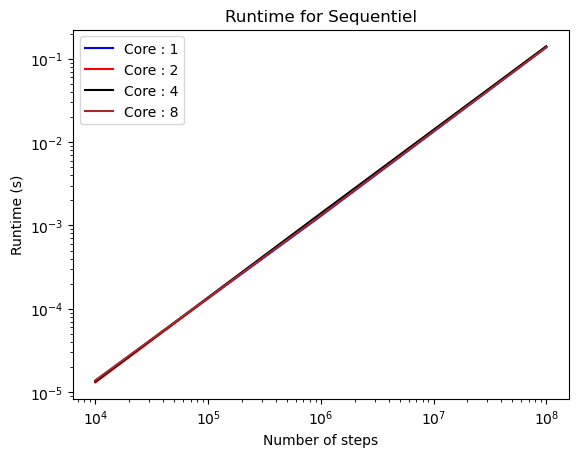

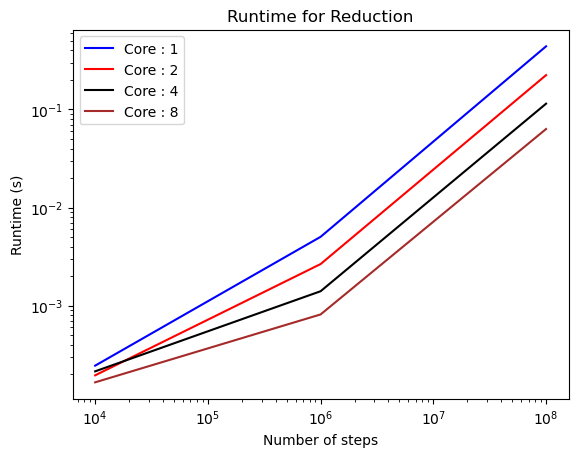

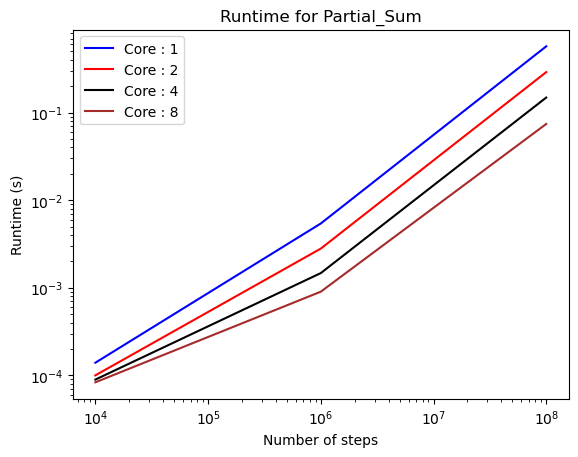

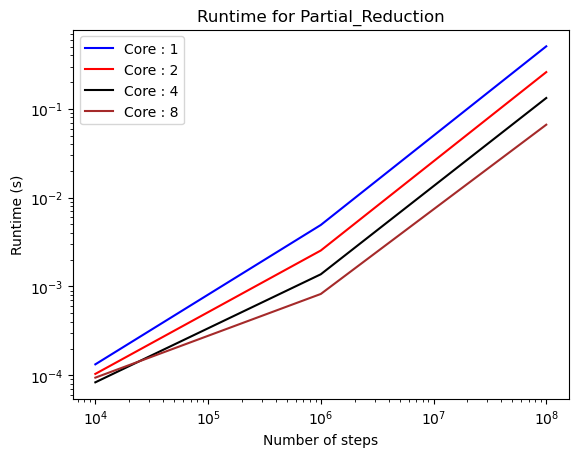

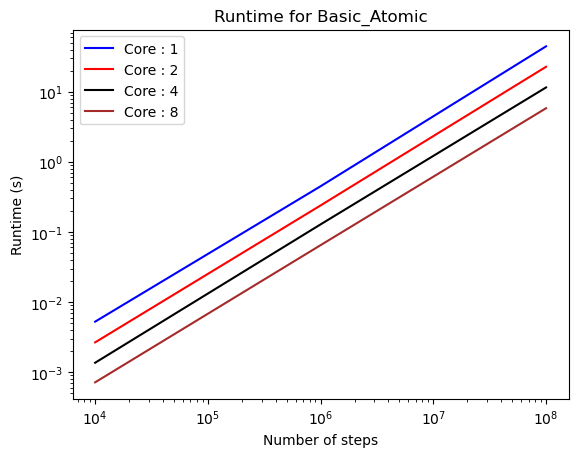

In [6]:
for algo in algo_compare:
    df_algo = df[df['version'] == algo]
    mean = df_algo.groupby(['nbcore', "num_steps"]).mean().reset_index()
    for core in nb_core:
        df_core = mean[mean['nbcore'] == core]
        plt.plot(df_core['num_steps'], df_core['runtime'], color=color_core[core], label="Core : " + str(core))
    plt.legend()
    plt.title("Runtime for " + algo)
    plt.xlabel("Number of steps")
    plt.ylabel("Runtime (s)")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()




On peux remarqué que le nombre de core n'affecte pas le temps d'éxécution du premier programme. Cela est dû au fait que le programme est séquentiel. Les autres algorithmes sont parallélisés et on remarque que le temps d'éxécution diminue avec le nombre de core.

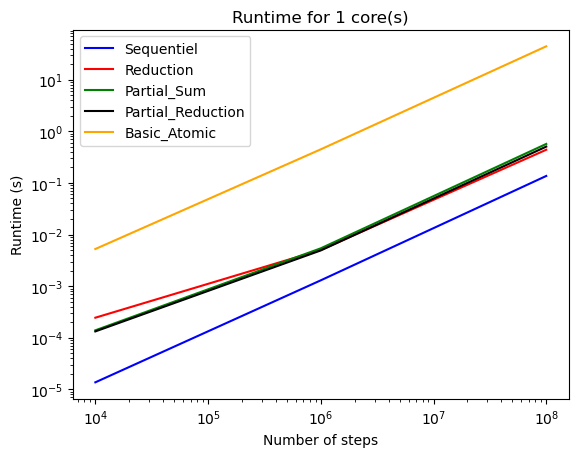

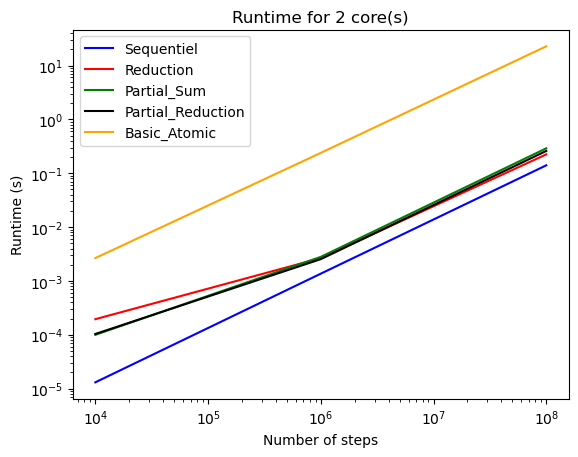

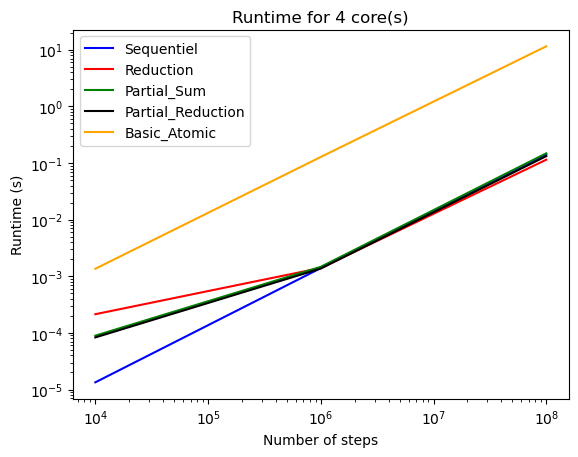

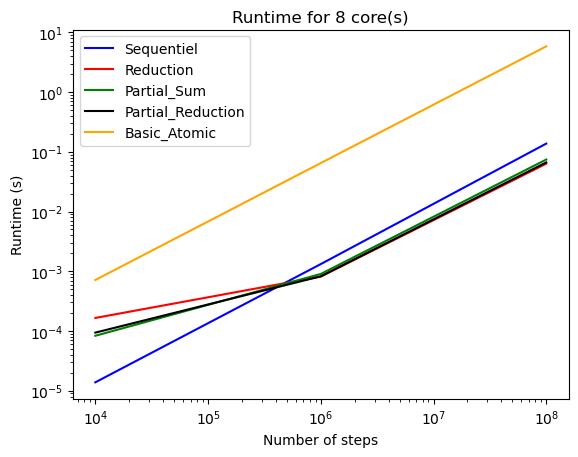

In [6]:
for core in nb_core:
    df_core = df[df['nbcore'] == core]
    mean = df_core.groupby(['version', "num_steps"]).mean().reset_index()
    for algo in algo_compare:
        df_algo = mean[mean['version'] == algo]
        plt.plot(df_algo['num_steps'], df_algo['runtime'], color=color_algo[algo], label=algo)
    plt.legend()
    plt.title("Runtime for " + str(core) + " core(s)")
    plt.xlabel("Number of steps")
    plt.ylabel("Runtime (s)")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

On peux voir que l'algorithme utilisant les atomic est vraiment très peu performant par rapport aux autres. Cela est dû au fait que les atomic sont très couteux en temps d'éxécution. De plus, l'algorithme sequentiel est executé sur le CPU et non le GPU. Il n'est donc pas pertinent.


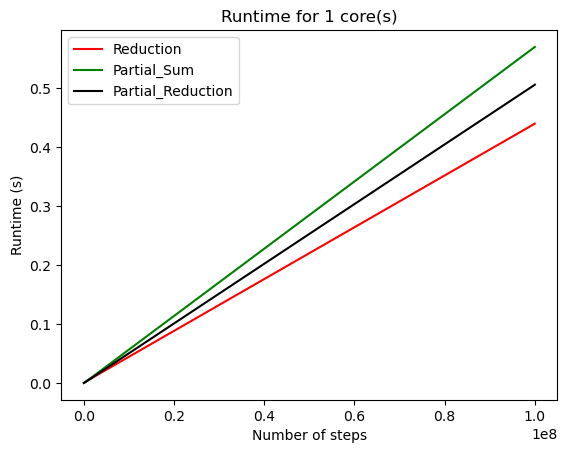

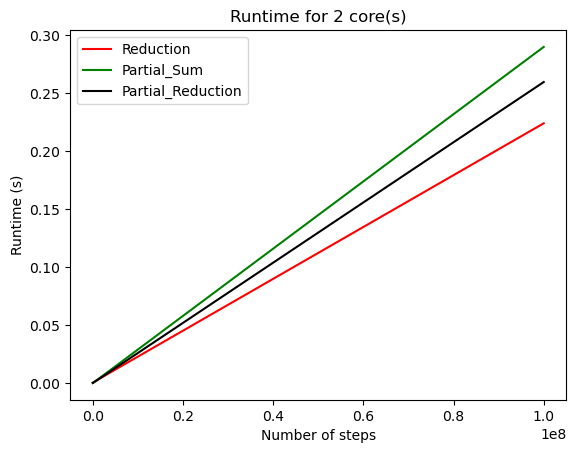

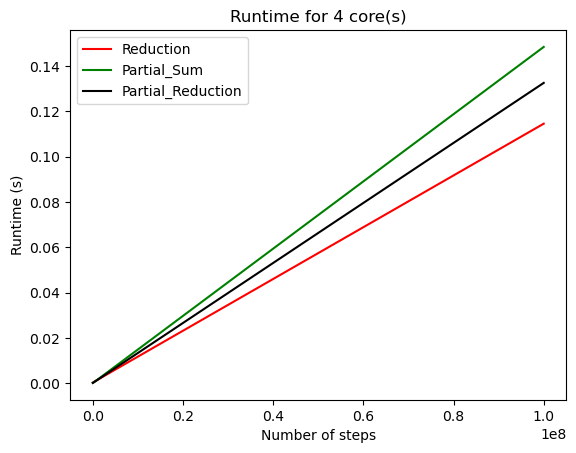

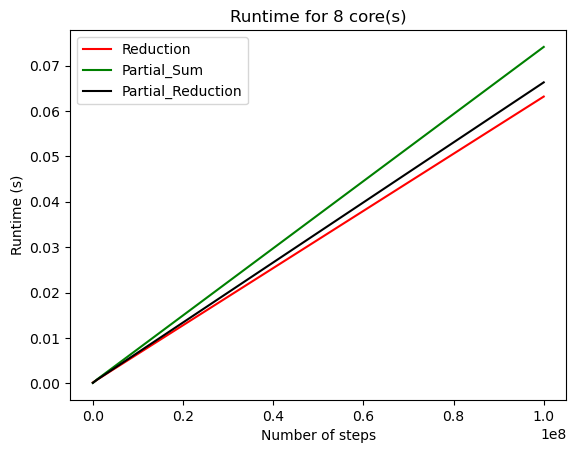

In [9]:
for core in nb_core:
    df_core = df[df['nbcore'] == core]
    mean = df_core.groupby(['version', "num_steps"]).mean().reset_index()
    for algo in algo_compare:
        if algo != "Sequentiel" and algo != "Basic_Atomic":
            df_algo = mean[mean['version'] == algo]
            plt.plot(df_algo['num_steps'], df_algo['runtime'], color=color_algo[algo], label=algo)
    plt.legend()
    plt.title("Runtime for " + str(core) + " core(s)")
    plt.xlabel("Number of steps")
    plt.ylabel("Runtime (s)")
    #plt.yscale('log')
    #plt.xscale('log')
    plt.show()

On peux donc voir que l'algorithme de réduction est plus rapide ques les autres, ce qui est normal, il a été optimisé. De plus, la version partial reduction est une version optimisée de l'algorithme partial sum.